In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fmin_slsqp

### Equilibrium Composition - Dry Reforming of Methane

Equilibrium Thermodynamics of the Dry Reforming Reaction Depicting the Conversion of Reactants CH$_4$ and CO$_2$ to CO, H$_2$, H$_2$O, and C as a Function of Temperature.

You can also see the following article\
https://doi.org/10.1016/j.joule.2018.02.017

### 1st method with CANTERA

In [2]:
# create empty list to store data
ch4_eq_combined = []
co2_eq_combined = []
h2o_eq_combined = []
h2_eq_combined = []
co_eq_combined = []
c_eq_combined = []
h2_co_ratio_combined = []
Xch4_eq_combined = []
Xco2_eq_combined = []
Xh2_eq_combined = []
Xco_eq_combined = []

In [3]:
Temp_range = np.linspace(300+273.15, 1000+273.15, 10)

for Temp in Temp_range:

    gas = ct.Solution('gri30.yaml')
    molar_ratio = {'CH4': 1/2, 'CO2':1/2, 'H2O':0.0, 'H2':0.0, 'CO':0.0, 'C': 0.0}
    pressure = 101325
    gas.TPX = Temp, pressure, molar_ratio
    
    # transport properties
    feed = gas['CH4', 'CO2', 'H2O', 'H2', 'CO', 'C']
             
    ρ_mix = (feed.density, 'kg/m^3')
    H_mix_mass = (feed.enthalpy_mass, 'J/kg')
    H_mix_mole = (feed.enthalpy_mole, 'J/kmol')
    cp_mix_mass = (feed.cp_mass, 'J/Kg/K')
    cp_mix_mole = (feed.cp_mole, 'J/kmol/K')
    Mr_mix = (feed.mean_molecular_weight, 'kg/kmol')
    n_species = feed.n_selected_species
    Di_mole = (feed.mix_diff_coeffs_mole, 'm^2/s')
    μ = (feed.viscosity, 'Pa*s')
    
    # partial molar properties
    Yi_feed = feed.Y # mass fractions
    Xi_feed = feed.X # molar fractions
    Mri = (feed.molecular_weights, 'kg/kmol')
    cpi = (feed.partial_molar_cp/1000, 'J/mol/K')
    Hi = (feed.partial_molar_enthalpies/1000, 'J/mol')
    Ci = (feed.concentrations, 'kmol/m^3')
    
    # equilibrate temperature, pressure
    feed.equilibrate('TP')
    
    ch4_eq = feed.X[0]*1
    ch4_eq_combined.append(ch4_eq)

    co2_eq = feed.X[1]*1
    co2_eq_combined.append(co2_eq)    
    
    h2o_eq = feed.X[2]
    h2o_eq_combined.append(h2o_eq)        
    
    h2_eq = feed.X[3]
    h2_eq_combined.append(h2_eq)    
    
    co_eq = feed.X[4]
    co_eq_combined.append(co_eq)       
    
    c_eq = feed.X[5]
    c_eq_combined.append(c_eq) 
    
    h2_co_ratio = h2_eq/co_eq   
    h2_co_ratio_combined.append(h2_co_ratio)
    
    # conversions
    Xch4_eq = ((molar_ratio['CH4'] - ch4_eq)/molar_ratio['CH4'])*100
    Xch4_eq_combined.append(Xch4_eq)
    
    Xco2_eq = ((molar_ratio['CO2'] - co2_eq)/molar_ratio['CO2'])*100
    Xco2_eq_combined.append(Xco2_eq)  
    
    Xh2_eq = ((h2_eq)/(2*molar_ratio['CH4']))*100
    Xh2_eq_combined.append(Xh2_eq)      
    
    Xco_eq = ((co_eq)/(molar_ratio['CO2'] + molar_ratio['CH4']))*100
    Xco_eq_combined.append(Xco_eq)

### 2nd method with GIBBS MINIMIZATION - (NIST DATA)

In [4]:
species = ['CH$_4$', 'CO$_2$', 'H$_2$O', 'H$_2$', 'CO', 'C']
ch4, co2, h2o, h2, co, c = np.arange(6)

def therm(T):
   
    # Heats of formation at 298.15 K in kJ/mol
    Hf298 = [
        -74.85,   # CH4
        -393.51,  # CO2
        -241.826, # H2O
           0.0,   # H2
        -110.53,  # CO
         716.67   # C
               ]   

    # Shomate parameters for each species
    #           A          B           C          D          E            F          G       H
    WB = [
          [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],       # CH4
          [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],       # CO2
          [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],       # H2O
          [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,    0.0],          # H2        
          [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271],       # CO
          [21.17510,    -0.812428, 0.448537,  -0.043256, -0.013103, 710.3470, 183.8734, 716.6690]             # C
    ]     

    WB = np.array(WB)

    # Shomate equations
    t = T/1000
    T_H = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0])
    T_S = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0])

    H = np.dot(WB, T_H)        # (H - H_298.15) kJ/mol
    S = np.dot(WB, T_S/1000.0) # absolute entropy kJ/mol/K

    Gjo = Hf298 + H - T*S  
    
    return Gjo

therm(1000)

array([-284.21955883, -629.41314825, -448.563659  , -145.536002  ,
       -323.37745308,  547.991314  ])

### Gibbs energy of a mixture

$\frac{G}{RT}={\sum_{j=1}^n n_j}(\frac{G_J^o}{RT}+ln\frac{n_j}{\sum n_j}\frac{P}{P_o})$

In [5]:
def func(nj):
    
    Gj =  therm(T) / (R * T) + np.log(nj / np.sum(nj) * P / Po)
    
    return np.dot(nj, Gj)

In [6]:
               # CH4,  CO2,  H2O,   H2,   CO,   C 
Aeq = np.array([[ 1,    1,    0,    0,    1,    1],   # C balance
                [ 0,    2,    1,    0,    1,    0],   # O balance
                [ 4,    0,    2,    2,    0,    0]])  # H balance

# equimolar feed ratio of 1 mol CH4 and 1 mol CO2
beq = np.array([2,  # mol C fed
                2,  # mol O fed
                4]) # mol H fed
              
def ec1(nj):
    'conservation of atoms constraint'
    return np.dot(Aeq, nj) - beq

In [7]:
R = 8.314e-3 # kJ/mol/K
P = 1.0 # atm, this is the total pressure in the reactor
Po = 1.0 # atm, this is the standard state pressure
inlet_ratio = np.array([1/2, 1/2, 0.0, 0.0, 0.0, 0.0])

yj = [] # molar ratio composition 
Temp_range = np.linspace(300+273.15, 1000+273.15, 10)
bnds = [(0.0, 2.0), (0.0, 2.0), (0.0, 2.0), (0.0, 2.0), (0.0, 2.0), (0.0, 2.0)]

for T in Temp_range:
    
    n0 = [0.5, 0.5, 0.01, 0.01, 0.01, 0.01]  # initial guesses
    sol = fmin_slsqp(func, n0, f_eqcons=ec1, bounds = bnds)
    yj.append(sol.T/sum(sol.T))

C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_12952\2102511305.py:3: RuntimeWarning: divide by zero encountered in log
  Gj =  therm(T) / (R * T) + np.log(nj / np.sum(nj) * P / Po)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -149.4921378968194
            Iterations: 12
            Function evaluations: 92
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -138.52273001272832
            Iterations: 17
            Function evaluations: 129
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -130.25430724199234
            Iterations: 8
            Function evaluations: 63
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -124.12021951338527
            Iterations: 16
            Function evaluations: 125
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -119.81786103483664
            Iterations: 16
            Function

In [8]:
yj = np.array(yj)
yj

array([[4.94551381e-01, 4.91376344e-01, 3.17503643e-03, 2.27358300e-03,
        8.62365586e-03, 3.93730058e-14],
       [4.75630011e-01, 4.64464042e-01, 1.11659685e-02, 1.32040206e-02,
        3.55359576e-02, 4.15493410e-12],
       [4.23190718e-01, 3.96598817e-01, 2.65919014e-02, 5.02173803e-02,
        1.03401183e-01, 8.03542897e-18],
       [3.21326277e-01, 2.78690077e-01, 4.26361996e-02, 1.36037524e-01,
        2.21309923e-01, 5.11142800e-18],
       [1.91791460e-01, 1.47629423e-01, 4.41620365e-02, 2.64046504e-01,
        3.52370577e-01, 9.65191084e-18],
       [8.91434961e-02, 5.89140898e-02, 3.02294063e-02, 3.80627098e-01,
        4.41085910e-01, 6.46307334e-18],
       [3.64836292e-02, 2.06640505e-02, 1.58195787e-02, 4.47696792e-01,
        4.79335950e-01, 7.09049729e-15],
       [1.49787153e-02, 7.38374807e-03, 7.59496724e-03, 4.77426317e-01,
        4.92616252e-01, 3.37865660e-13],
       [6.74537324e-03, 2.88073862e-03, 3.86463462e-03, 4.89389992e-01,
        4.97119261e-01, 

### Equations used

$X_{CH_4}=\frac{F_{CH_4,in}-F_{CH_4,out}}{F_{CH_4,in}}x100$

$X_{CO_4}=\frac{F_{CO_2,in}-F_{CO_2,out}}{F_{CO_2,in}}x100$

$Y_{H_2}=\frac{F_{H_2,out}}{2F_{CH_4,in}}x100$

$Y_{CO}=\frac{F_{CO,out}}{F_{CH_4,in}+F_{CO_2,in}}x100$

$Molar~ratio = \frac{F_{H_2,out}}{F_{CO,out}}$

In [9]:
# conversions
Xch4_equilbrium = ((inlet_ratio[ch4] - yj.T[ch4])/inlet_ratio[ch4])*100
Xco2_equilbrium = ((inlet_ratio[co2] - yj.T[co2])/inlet_ratio[co2])*100

# yields
Yh2_equilbrium = ((yj.T[h2])/(2*inlet_ratio[ch4]))*100
Yco_equilbrium = ((yj.T[co])/(inlet_ratio[ch4] + inlet_ratio[co2]))*100

# ratio h2/co
h2_co = yj.T[h2]/yj.T[co]

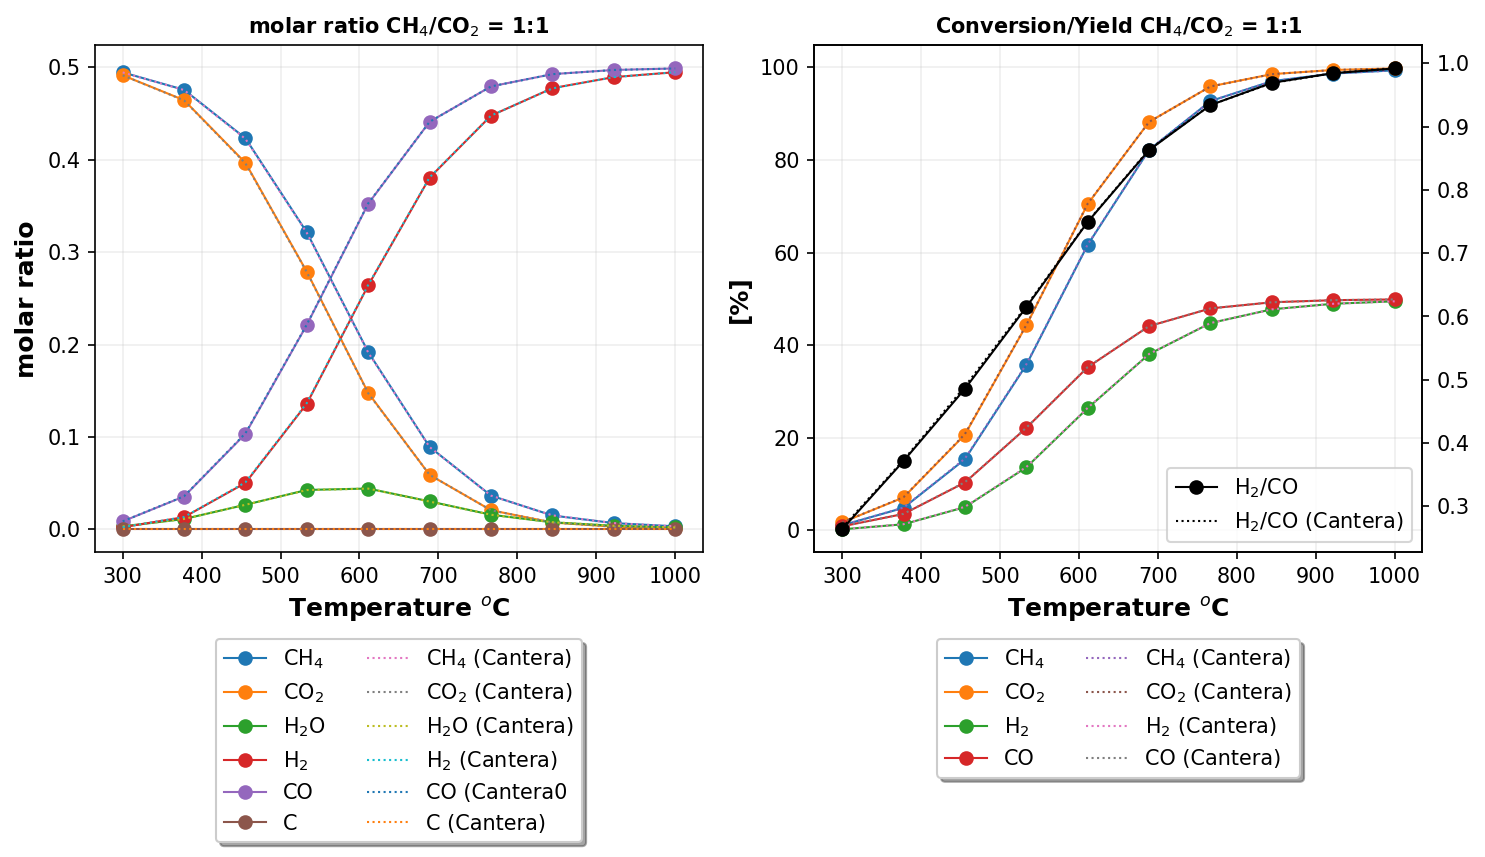

In [10]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,6), dpi = 150)

for j, arr in enumerate(yj.T):
    ax[0].plot(Temp_range - 273.15, arr, "-o", label = species[j], lw = 1)
       
ax[0].set_title('molar ratio CH$_4$/CO$_2$ = 1:1', fontsize=10, fontweight='bold')
ax[0].set_ylabel('molar ratio', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')
ax[0].grid(ls="-", alpha = 0.2)

# Cantera plots
ax[0].plot(Temp_range-273.15, ch4_eq_combined, ':', label = 'CH$_4$ (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, co2_eq_combined, ':', label = 'CO$_2$ (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, h2o_eq_combined, ':', label = 'H$_2$O (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, h2_eq_combined, ':', label = 'H$_2$ (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, co_eq_combined, ':', label = 'CO (Cantera0', lw = 1)
ax[0].plot(Temp_range-273.15, c_eq_combined, ':', label = 'C (Cantera)', lw = 1)


ax[1].plot(Temp_range - 273.15, Xch4_equilbrium, "-o", label = 'CH$_4$', lw = 1)
ax[1].plot(Temp_range - 273.15, Xco2_equilbrium, "-o", label = 'CO$_2$', lw = 1)
ax[1].plot(Temp_range - 273.15, Yh2_equilbrium, "-o", label = 'H$_2$', lw = 1)
ax[1].plot(Temp_range - 273.15, Yco_equilbrium, "-o", label = 'CO', lw = 1)
ax[1].set_title('Conversion/Yield CH$_4$/CO$_2$ = 1:1', fontsize=10, fontweight='bold')
ax[1].set_ylabel('[%]', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')

ax[1].plot(Temp_range-273.15, Xch4_eq_combined, ':', label = 'CH$_4$ (Cantera)', lw = 1)
ax[1].plot(Temp_range-273.15, Xco2_eq_combined, ':', label = 'CO$_2$ (Cantera)', lw = 1)
ax[1].plot(Temp_range-273.15, Xh2_eq_combined, ':', label = 'H$_2$ (Cantera)', lw = 1)
ax[1].plot(Temp_range-273.15, Xco_eq_combined, ':', label = 'CO (Cantera)', lw = 1)
ax[1].grid(ls="-", alpha = 0.2)

ax_b = ax[1].twinx()
ax_b.plot(Temp_range-273.15, h2_co, "ko-", label = 'H$_2$/CO', lw = 1)
ax_b.plot(Temp_range-273.15, h2_co_ratio_combined, 'k:', label = 'H$_2$/CO (Cantera)', lw = 1)

# Legends
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)
ax_b.legend(loc = "lower right")

fig.tight_layout()

### Observations

Excellent convergence between two methods